In [1]:
import tensorflow as tf
from keras.datasets import mnist
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
%matplotlib inline

Using TensorFlow backend.


In [2]:
from IPython.display import clear_output, Image, display, HTML

# Helper functions for TF Graph visualization

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
        

In [6]:
# Restore model.
sess = tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph('tf_mnist_model_layers/tf_mnist_model.ckpt.meta')
saver.restore(sess,tf.train.latest_checkpoint('tf_mnist_model_layers/'))
show_graph(sess.graph)

INFO:tensorflow:Restoring parameters from tf_mnist_model_layers/tf_mnist_model.ckpt


Load the data

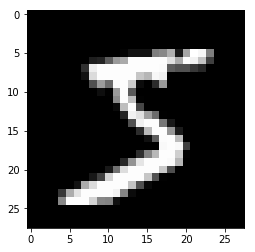

In [8]:
dataset = mnist.load_data()
train_data = dataset[0][0] / 255
train_data = train_data[..., np.newaxis].astype('float32')
train_labels = np_utils.to_categorical(dataset[0][1]).astype('float32')
test_data = dataset[1][0] / 255
test_data = test_data[..., np.newaxis].astype('float32')
test_labels = np_utils.to_categorical(dataset[1][1]).astype('float32')
plt.imshow(train_data[0, ..., 0])

In order to do infernce one has to know which tensor holds the relevant predictions, at least if one is using the plain graph and not the `estimator API`. One also has to recover the input tensor to feed the data to.

In [4]:
sess.graph.get_operations()

[<tf.Operation 'Placeholder' type=Placeholder>,
 <tf.Operation 'Placeholder_1' type=Placeholder>,
 <tf.Operation 'training/input' type=Const>,
 <tf.Operation 'training' type=PlaceholderWithDefault>,
 <tf.Operation 'conv2d_1/kernel/Initializer/truncated_normal/shape' type=Const>,
 <tf.Operation 'conv2d_1/kernel/Initializer/truncated_normal/mean' type=Const>,
 <tf.Operation 'conv2d_1/kernel/Initializer/truncated_normal/stddev' type=Const>,
 <tf.Operation 'conv2d_1/kernel/Initializer/truncated_normal/TruncatedNormal' type=TruncatedNormal>,
 <tf.Operation 'conv2d_1/kernel/Initializer/truncated_normal/mul' type=Mul>,
 <tf.Operation 'conv2d_1/kernel/Initializer/truncated_normal' type=Add>,
 <tf.Operation 'conv2d_1/kernel' type=VariableV2>,
 <tf.Operation 'conv2d_1/kernel/Assign' type=Assign>,
 <tf.Operation 'conv2d_1/kernel/read' type=Identity>,
 <tf.Operation 'conv2d_1/bias/Initializer/zeros' type=Const>,
 <tf.Operation 'conv2d_1/bias' type=VariableV2>,
 <tf.Operation 'conv2d_1/bias/Assign'

In [13]:
input_tensor = sess.graph.get_operations()[0].outputs[0]
input_tensor

<tf.Tensor 'Placeholder:0' shape=(?, 28, 28, 1) dtype=float32>

In [20]:
prediction_tensor = sess.graph.get_operation_by_name('dense_2/BiasAdd').outputs[0]
prediction_tensor

<tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 10) dtype=float32>

In [23]:
np.argmax(
    sess.run(prediction_tensor, feed_dict={input_tensor: test_data[:5]}),
    axis=-1)

array([7, 2, 1, 0, 4])

Let's check whether the network was right.

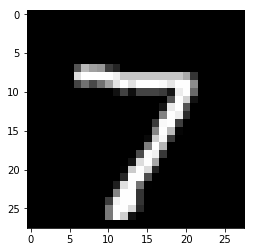

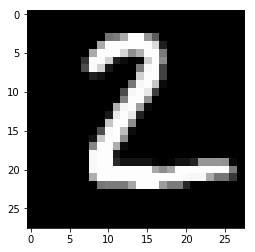

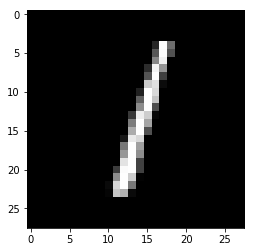

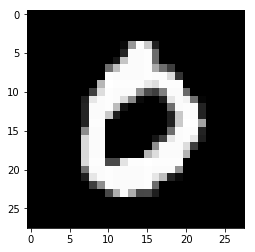

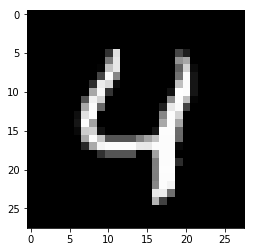

In [25]:
for i in range(5):
    plt.imshow(test_data[i, ..., 0])
    plt.show()